In [1]:
import numpy as np
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
import scipy.interpolate
import time
from scipy.optimize import curve_fit
import math
from numba import njit

In [2]:
import matplotlib as mpl
mpl.use('pgf')
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as mticker
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline

myColors = ["#009E73", "#0072B2", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#E69F00", "#000000"]
colors= ["white", myColors[4], myColors[1], myColors[0], myColors[5], myColors[6], myColors[3]]
myNodes = [0.0, 0.1, 0.2, 0.35, 0.5, 0.85, 1.0]
myCmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(myNodes, colors)))

colorsLog= ["white",  myColors[4], myColors[1], myColors[6], myColors[3], myColors[3]]
myNodesLog = [0.0, 0.1 , 0.2, 0.36, 0.6, 1]
myCmapLog = mpl.colors.LinearSegmentedColormap.from_list("mycmapLog", list(zip(myNodesLog, colorsLog)))

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams.update({'font.size': 15})

mpl.rcParams['axes.prop_cycle'] = cycler(color=myColors)

In [3]:

def RescalingCenters(DataSet, Nbins, Bins_limit=None):

    if Bins_limit==None:
        bins_max=DataSet[-1][0]
        bins_min=DataSet[0][0]
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]
        
    x_data=DataSet[:,0]
    bins_edges = np.logspace(np.log10(bins_min), np.log10(bins_max), Nbins+1)
    bins_centers = np.array([0.5 * (bins_edges[i] + bins_edges[i+1]) for i in range(Nbins)])
    y_data=DataSet[:,1]

    y_stackable = np.zeros(Nbins)

    for j in range(Nbins):
        for i in range(len(x_data)):
            if (x_data[i]<bins_edges[j+1])and(x_data[i]>bins_edges[j]):
                x_data[i]=bins_centers[j]
                y_stackable[j]=round(y_data[i])
            else:
                pass
        
    return bins_edges, bins_centers,  y_stackable

In [4]:
def DataStack(DataSets, Nbins, Bins_limit=None):

    if Bins_limit==None:
        a=np.empty(len(DataSets), dtype=object)
        for i in range(len(DataSets)):
            a[i] = DataSets[i][:,0]
        a=np.concatenate(a)
        
        bins_max=max(a)

        bins_min=min(a)

        bins_limit=(bins_min, bins_max)
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]


    y_stacked = np.zeros(Nbins)
    for i in range(len(DataSets)):

        bins_edges, bins_center, y_stackable = RescalingCenters(DataSets[i], Nbins, Bins_limit=(bins_min, bins_max))
        y_stacked += y_stackable
    

    return bins_edges, bins_center, y_stacked

In [5]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_N_per_halo = 'Stars_per_minihalo'
N_per_halos = np.rint(np.genfromtxt(pathfit_susa + 'N_per_halos' +'.csv'))
x_bins=np.arange(1,7,1)


In [6]:
def PowerLaw(x, A, a):
    return A*np.exp(-x*a)

In [7]:
x_fit_NH = np.arange(1, 7, 0.1)
sample=[]
popt, pcov = curve_fit(PowerLaw, x_bins, N_per_halos,  bounds=([18, 0], [30, 10]))
y_fit_NH = PowerLaw(x_fit_NH, *popt)
A, a = popt
N_tot = np.sum(N_per_halos)

Text(0, 0.5, 'Number of halo')

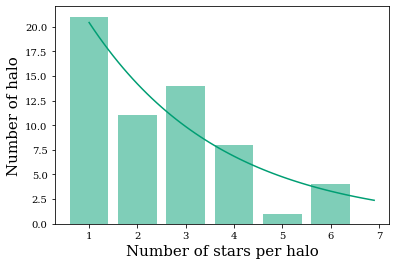

In [8]:
plt.bar(x_bins, N_per_halos, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH, color=myColors[0])

plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')

In [9]:
N_per_halos_z30 = np.array([0.8, 0.2, 0., 0., 0., 0.])
popt30, pcov30 = curve_fit(PowerLaw, x_bins, N_per_halos_z30,  bounds=([18, 0], [30, 10]))
y_fit_NH_30 = PowerLaw(x_fit_NH, *popt30)

A30, a30 = popt30

In [10]:
def PowerLaw_norm(x, A, a):
    N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
    return A*np.exp(-x*a)


In [11]:
N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
N_per_halos_z10 = N_per_halos/N_NH

popt10, pcov10 = curve_fit(PowerLaw_norm, x_bins, N_per_halos_z10,  bounds=([0, 0], [30, 10]))
y_fit_NH_10 = PowerLaw(x_fit_NH, *popt10)

A10, a10 = popt10

Text(0, 0.5, 'Number of halo')

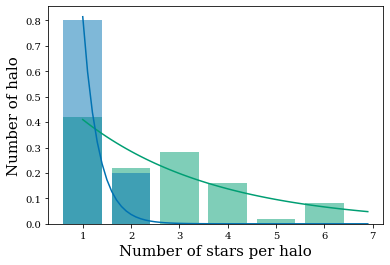

In [12]:

y_fit_norm = y_fit_NH/N_NH

plt.plot(x_fit_NH, y_fit_NH_10, color=myColors[0])
plt.bar(x_bins, N_per_halos_z10, alpha = 0.5)
plt.bar(x_bins, N_per_halos_z30, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH_30, color=myColors[1])

plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')


In [13]:
def Az(z):
    # A_int = scipy.interpolate.UnivariateSpline((10, 30),(A10, A30))
    A_int =  scipy.interpolate.krogh_interpolate((10, 30),(A10, A30), z)
    return float(A_int)

def az(z):
    # a_int = scipy.interpolate.UnivariateSpline((10, 30),(a10, a30))
    a_int =  scipy.interpolate.krogh_interpolate((10, 30),(a10, a30), z)
    return float(a_int)

def PowerLaw_PDF_Z(n_s, z):
    def PowerLaw_z(n_s, z):
        A = Az(z)
        a = az(z)
        N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
        return A*np.exp(-n_s*a)/N_NH
    v= np.vectorize(PowerLaw_z)
    return v(n_s, z)

In [14]:
n_s = np.linspace(1, 7, 100)
z = np.linspace(10, 30, 100)

x, y = np.meshgrid(n_s, z)

pl = np.array(PowerLaw_PDF_Z(x, y))

N_star_prob = scipy.interpolate.interp2d(n_s, z, pl, kind='cubic')

In [15]:
def N_star_pdf(n_s, z):
    n = np.vectorize(N_star_prob)
    return n(n_s, z)

Text(0, 0.5, '$P(N_*)$')

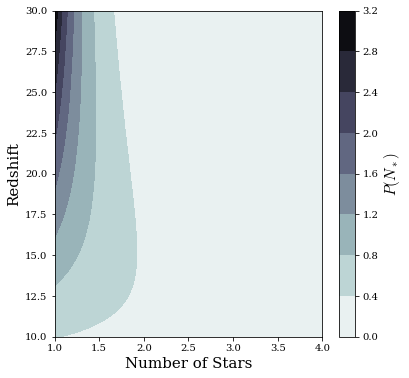

In [16]:
fig1, ax2 = plt.subplots(figsize=(6 , 6))

origin = 'lower'

n_s = np.linspace(1, 7, 100)
z = np.linspace(10, 30, 100)

CS = ax2.contourf(n_s, z, N_star_prob(n_s, z), cmap=plt.cm.bone_r, origin=origin)

ax2.set_xlabel('Number of Stars')
ax2.set_ylabel('Redshift')
ax2.set_xlim(1, 4)

# CS2 = ax2.contour(CS, levels=CS.levels[::1], colors='r', origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$P(N_*)$')

# cbar.add_lines(CS2)

We want to build a monte carlo that return the number of star par mass of halos with an associated mass. 
To do so we needed the IMF of the halos, the distribution of stars in the halos and their IMFwe have now everything we wanted to perform this.

In [8]:
from PS_class import HaloMassFunction

In [9]:
HMF = HaloMassFunction(0, logmass_lim=(4, 20), Nbins=100)

gen = np.random.default_rng()

H_IMF = HMF.IMF

z = np.linspace(10, 30, 100)
Mh_interval=(10**4, 10**10)
m = np.logspace(np.log10(Mh_interval[0]), np.log10(Mh_interval[1]), 100)

In [10]:
xh, yh = np.meshgrid(m, z)

h = H_IMF(xh, yh)

In [11]:
h_inter = scipy.interpolate.interp2d(m, z, h, kind='cubic')

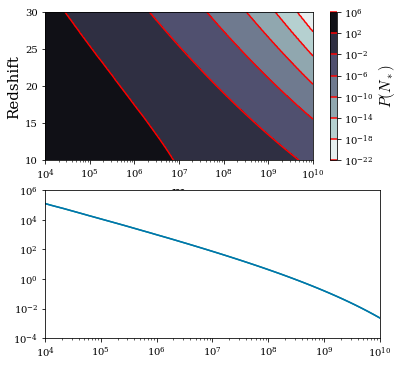

In [12]:
fig1, ax2 = plt.subplots(2, figsize=(6 , 6))

origin = 'lower'

CS = ax2[0].contourf(m, z, h_inter(m,z), cmap=plt.cm.bone_r, origin=origin, locator=mpl.ticker.LogLocator())

ax2[0].set_xlabel('m')
ax2[0].set_xscale('log')
ax2[0].set_ylabel('Redshift')
CS2 = ax2[0].contour(CS, levels=CS.levels[::1], colors='r', origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$P(N_*)$')
m2 = np.logspace(4, 15, 100)
ax2[1].plot(m2, h_inter(m2, 10))
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')
ax2[1].plot(m2, H_IMF(m2, 10))
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')

ax2[1].set_ylim(1e-4,1e6)
ax2[1].set_xlim(1e4,1e10)

cbar.add_lines(CS2)

In [13]:
def halo_PDF_norm(z):
    return integrate.quad(h_inter, Mh_interval[0], Mh_interval[1], args=(z), epsrel=1e-4, limit=1000)[0]

halo_PDF_norm(11)

7322122484.518658

In [14]:
from PS_class import GrowthFunction

GF = GrowthFunction()

In [15]:
from PS_class import Overdensities
O=Overdensities(0)
@njit
def derivative(M):
        sigma = O.S(M)
        sigma_plus = O.S(1.000000001*M)
        return (sigma_plus-sigma)/(0.000000001*M)

def M_finder(M0, sigma):
        return float(scipy.optimize.fsolve(lambda x: O.S(x)-sigma, M0))

m_finder =np.vectorize(M_finder)
        
def S_for_M(M, sigma_MF):
    return O.S(M)-sigma_MF



In [16]:
Mh_interval=(10**4, 10**10)
def HalosGenerator(ninput, z):

    norm = halo_PDF_norm(z)

    def pdf(m):
        return h_inter(m, z)/norm
    
    m_int = np.logspace(4, 10, 100)
    pdf_int = scipy.interpolate.interp1d(m_int, pdf(m_int))

    fmax=pdf_int(Mh_interval[0])+0.02*pdf_int(Mh_interval[0])
    x_output=np.array([])
    
    ii=0
    t=[]
    while ii<ninput:

        # t0 = time.time()
        # t.append(time.time()-t0)

        x = gen.uniform(*Mh_interval, 10000)
        y = gen.uniform(0, fmax, 10000)

        x_accepted = x[(y <= pdf_int(x))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        ii+=len(x_accepted)
        print('halos', ii)

        

        # if(ii>=100):
        #     t_tot =np.mean(t)*ninput
        #     print(" Time for 1 loop is approx:", np.mean(t)
        #         , "\n Comp is finished in ", t_tot, "s"
        #         , " = " , t_tot/60 , "min" )
    
    return x_output[:ninput]



In [17]:
n_halos=1000

Halos = HalosGenerator(n_halos, 10)

halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 0
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 2
halos 2
halos 2
halos 2
halos 2
halos 2
halos 2
halos 2
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 3
halos 4
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 5
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 6
halos 7
halos 7
halos 7
halos 7
halos 7


In [19]:
Halos

array([4.14192626e+04, 1.30983541e+04, 2.34212951e+06, 2.70304337e+05,
       4.25275348e+06, 1.55697850e+05, 5.95238475e+05, 8.64868135e+05,
       2.40002323e+09, 8.58108271e+04, 6.30215097e+06, 5.16754663e+04,
       3.65909688e+07, 2.56068476e+04, 2.73310120e+05, 9.01183149e+04,
       5.27713252e+05, 1.71776023e+06, 1.35785260e+07, 6.64251958e+04,
       5.26413919e+05, 5.00285807e+04, 7.14737891e+07, 3.11841808e+04,
       4.35671325e+06, 3.27777166e+05, 1.69701085e+04, 5.59917758e+05,
       2.35281701e+04, 4.08792949e+08, 5.85657292e+05, 1.76794568e+06,
       4.88613040e+06, 6.15386295e+08, 1.17603503e+05, 1.91157216e+04,
       7.16393453e+06, 8.43446419e+04, 2.48967080e+06, 1.18024885e+04,
       2.17909110e+06, 2.09923310e+07, 5.83395700e+07, 1.10227326e+09,
       1.01327720e+04, 1.12613919e+07, 1.01550061e+07, 2.74580637e+05,
       1.86631029e+06, 2.47743500e+04, 4.17123502e+04, 1.93889418e+07,
       2.64865974e+05, 5.72788452e+06, 5.41629010e+04, 1.62293170e+06,
      

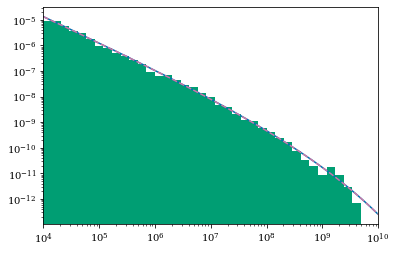

In [18]:
plt.hist(Halos, density=True, bins=10**np.linspace(4, 10, 40))
halo_PDF_norm_10 = halo_PDF_norm(10)
M=np.logspace(4, 10, 100)
plt.plot(M, h_inter(M, 10)/halo_PDF_norm_10)
plt.plot(M, H_IMF(M, 10)/halo_PDF_norm_10, '--')
plt.xlim(10**4, 10**10)
plt.xscale('log')
plt.yscale('log')

In [29]:
def N_StarGenerator(m_Hs, z):

    fmax=N_star_pdf(1, 10)+0.02*N_star_pdf(1, 10)
    x_output=np.array([])
    y_output=np.array([])

    ninput=len(m_Hs)
    
    ii = 0
    t = []
    while ii<ninput:

        x = gen.uniform(1, 7, ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= N_star_pdf(x, 10))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        y_accepted = y[(y <= N_star_pdf(x, 10))]
        y_output = (np.append(y_output, y_accepted)).flatten()
        ii+=len(x_accepted)
        # print('N_star', ii)

        x_output = x_output[:ninput]
        y_output = y_output[:ninput]
    
    return x_output, np.log10(m_Hs)/6*x_output, y_output

    


In [30]:
N_star = N_StarGenerator(Halos, 30)

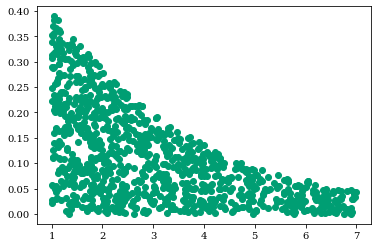

In [31]:
plt.scatter(N_star[0], N_star[2])

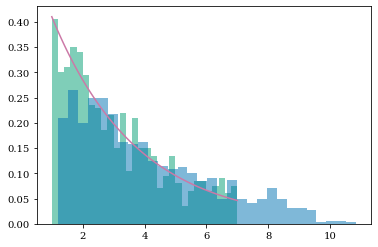

In [32]:
plt.hist(N_star[0], density=True, bins=30, alpha = 0.5)
plt.hist(N_star[1], density=True, bins=30, alpha = 0.5)
n_s=np.linspace(1, 7, 100)
plt.plot(n_s, N_star_prob(n_s, 10))

(array([0.05905906, 0.23723724, 0.21121121, 0.14314314, 0.11311311,
        0.08408408, 0.05705706, 0.06006006, 0.03503504]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 9 artists>)

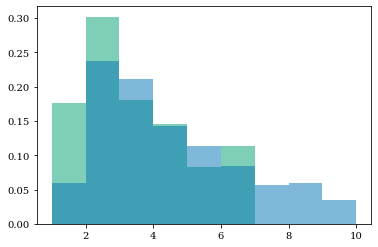

In [33]:
N_star_int_scaled = np.rint(N_star[1])[N_star[1]<11]
N_star_int_scaled = N_star_int_scaled[N_star_int_scaled<11]
N_star_int = np.rint(N_star[0])
N_star_int = N_star_int[N_star_int<11]

plt.hist(N_star_int, density=True, bins=6, alpha = 0.5)
plt.hist(N_star_int_scaled, density=True, bins=9, alpha = 0.5)

In [34]:
def Gaussian(x, s, mu):
    return (1 / (s*np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * s**2))

In [35]:
def Double_Gaussian(x, s1, mu1, A1, s2, mu2, A2):
    return A1 * np.exp(-(x - mu1)**2 / (2 * s1**2)) + A2 * np.exp(-(x - mu2)**2 / (2 * s2**2))

In [36]:
def HistMaker(bar_edges, bar_centers, bar_Y):
    data = []
    for i in range(len(bar_edges)-1):
        ii=1
        l1= len(data)
        while ii<=bar_Y[i]:
            data.append(np.log10(bar_centers[i]))
            ii+=1
        l2 = len(data)
        # print(l2-l1, bar_Y[i], np.array(data)[l1:l2])
    return data

In [37]:
#Hirano 2015
name_Hirano2015 = ['Total', '10<z<14', '14<z<18', '18<z<22', '22<z<26', '26<z<30', 'Bins']

pathfit_Hirano2015= '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Hirano2015/'
Hirano2015 = np.empty(len(name_Hirano2015), dtype=object)
for i in range(len(name_Hirano2015)):
    Hirano2015[i] = np.genfromtxt(pathfit_Hirano2015 + name_Hirano2015[i] +'.csv', delimiter=';')

Nbins_Hirano2015 = len(Hirano2015[0])
Bins_Hirano2015_min = min(Hirano2015[-1][:,0])
Bins_Hirano2015_max = max(Hirano2015[-1][:,0])
Bins_limit_Hirano2015=(Bins_Hirano2015_min, Bins_Hirano2015_max)


Hirano2015_Y=np.empty(len(Hirano2015), dtype=object)
Hirano2015_edges = np.empty(len(Hirano2015), dtype=object)
Hirano2015_centers = np.empty(len(Hirano2015), dtype=object)
Data_Hirano2015 = np.empty(len(Hirano2015), dtype=object)

for i in range(len(Hirano2015)):
    Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i] = RescalingCenters(Hirano2015[i], Nbins_Hirano2015, Bins_limit=Bins_limit_Hirano2015)
    Data_Hirano2015[i]= HistMaker(Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i])


(0.9911086115606538, 2.324458683825721e-09)
[0.11683528 1.3816745  1.40116422 0.25327232 2.18074878 0.91478506]
(0.9401219023557018, 2.246588450197768e-09)
[0.14016337 2.         0.53677288 0.1554906  2.35955187 1.92820967]
[0.15636607 2.43724364]
[0.09545854 2.51981353]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.125979   2.52119741]


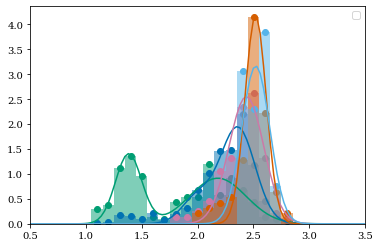

In [38]:
Hirano2015_popts = np.empty(5, dtype=object
                            )
for i in range(1, len(Data_Hirano2015)-1):
    mfit_pop3_h2015 = np.linspace(0.5, 3.5, 100)
    bin_entries, _, _  = plt.hist(Data_Hirano2015 [i], bins=np.linspace(np.log10(Bins_limit_Hirano2015[0]), np.log10(Bins_limit_Hirano2015[1]), 21), alpha = 0.5, density=True, color=myColors[i-1])   

    mask=(Hirano2015_Y[i]!=0)
    Hirano2015_centerf = np.log10(Hirano2015_centers[i])[mask]
    plt.scatter(np.log10(Hirano2015_centers[i])[mask], bin_entries[mask], color=myColors[i-1])


    if i<3:
        Hirano2015_popts[i-1], Hirano2015_pcov = curve_fit(Double_Gaussian, Hirano2015_centerf, bin_entries[mask], bounds=([0, 1, 0, 0, 2, 0],[1, 2, 10, 1, 3, 10]))
        s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[i-1]
        norm = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))
        print(norm)
        plt.plot(mfit_pop3_h2015, Double_Gaussian(mfit_pop3_h2015, *Hirano2015_popts[i-1]), color=myColors[i-1])
    elif i>=3:
        Hirano2015_popts[i-1], Hirano2015_pcov = curve_fit(Gaussian, Hirano2015_centerf, bin_entries[mask], bounds=([0,2],[1, 3]))
        plt.plot(mfit_pop3_h2015, Gaussian(mfit_pop3_h2015, *Hirano2015_popts[i-1]), color=myColors[i-1])
    
    print(Hirano2015_popts[i-1]) 

# plt.ylim(1, 1000)
plt.xlim(0.5, 3.5)
# plt.yscale('log')
plt.legend()

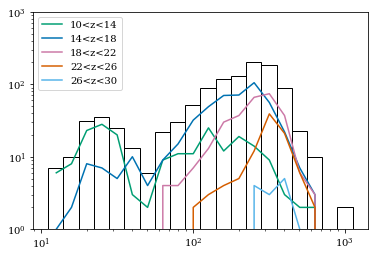

In [39]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(1, len(Hirano2015)-1):
    plt.plot(Hirano2015_centers[i], Hirano2015_Y[i], label=f'{name_Hirano2015[i]}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 1000)
plt.legend()

In [40]:
s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[0]
norm1 = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))
s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[1]
norm2 = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))

def Hirano2015_pdf(M, z):
    if 10<z and z<14:
        return Double_Gaussian(np.log10(M), Hirano2015_popts[0])/norm1
    elif 14<z and z<18:
        return Double_Gaussian(np.log10(M), Hirano2015_popts[1])/norm2
    elif 18<z and z<22:
        return Gaussian(np.log10(M), Hirano2015_popts[2])
    elif 22<z and z<26:
        return Gaussian(np.log10(M), Hirano2015_popts[3])
    elif 26<z and z<30:
        return Gaussian(np.log10(M), Hirano2015_popts[4])
    

In [41]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_susa = ['Bins edges', 'Hist']

Susa = np.genfromtxt(pathfit_susa + name_susa[1] +'.csv', delimiter=';')
Bins_limit_Susa=np.genfromtxt(pathfit_susa + name_susa[0] +'.csv', delimiter=';')[:,0].tolist()
Nbins_Susa = 20
Bins_limit_Susa

[0.464926482, 295.3916929]

In [42]:
Susa_edge, Susa_center, Susa_Y = RescalingCenters(Susa, Nbins_Susa, Bins_limit=Bins_limit_Susa)
Data_Susa_i = HistMaker(Susa_edge, Susa_center, Susa_Y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.52420984 1.38007314]


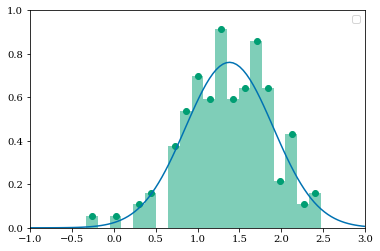

In [43]:
mfit_pop3 = np.linspace(-1, 3, 100)
bin_entries, _, _  = plt.hist(Data_Susa_i, bins=np.linspace(np.log10(Bins_limit_Susa[0]), np.log10(Bins_limit_Susa[1]), 21), alpha = 0.5, density=True)   

mask=(Susa_Y!=0)
Susa_centerf = np.log10(Susa_center)[mask]
plt.scatter(np.log10(Susa_center)[mask], bin_entries[mask])

Susa_popt, Susa_pcov = curve_fit(Gaussian, Susa_centerf, bin_entries[mask], bounds=([0,0],[10, 2]))

plt.plot(mfit_pop3, Gaussian(mfit_pop3, *Susa_popt))
print(Susa_popt) 

plt.ylim(0, 1)
plt.xlim(-1, 3)
plt.legend()

In [44]:
def Susa_IMF_PDF(m, z):
    return Gaussian(np.log10(m), *Susa_popt)

def Susa_IMF_PDF_log(logm, z):
    """
    this pdf is normlaized only for the log of the mass!
    """
    return Gaussian(logm, *Susa_popt)


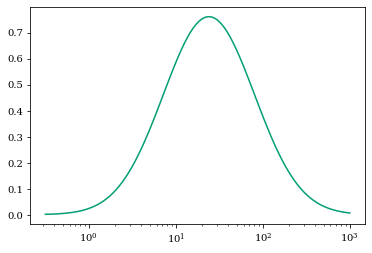

In [45]:
M=np.logspace(-0.5, 3, 100)
plt.plot(M, Susa_IMF_PDF(M, 10))
plt.xscale('log')

In [3]:
from scipy.stats import loguniform

def Mass_Star_Generator(ninput, z, PDF, logm_interval):
    m_max = np.logspace(logm_interval[0],  logm_interval[1], 100)
    pdfmax = np.max(PDF(m_max, z))
    fmax = pdfmax+0.02*pdfmax
    x_output = np.array([])
    y_output = np.array([])
    
    ii = 0
    while ii<ninput:

        x = loguniform.rvs(10**logm_interval[0], 10**logm_interval[1], size=ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= PDF(x, z))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        ii+=len(x_accepted)
        # print('Mass star', ii)

        x_output = x_output[:ninput]
    
    return x_output


In [4]:
star = Mass_Star_Generator(10000, 10, Susa_IMF_PDF, (-1, 3))

NameError: name 'Susa_IMF_PDF' is not defined

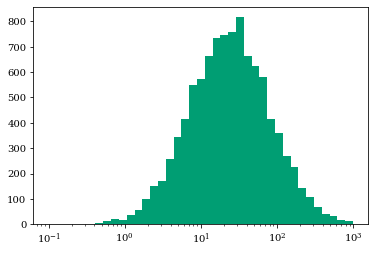

In [48]:
m = np.logspace(-1, 4, 100)
plt.hist(star, density=False, bins=10**np.linspace(-1,3,40))
# plt.plot(m, Susa_IMF_PDF(m, 10))
plt.xscale('log')

In [49]:
z=10
N_h = 1000
Mass_Halos = HalosGenerator(N_h, 30)


halos 4
halos 6
halos 8
halos 11
halos 19
halos 21
halos 25
halos 28
halos 34
halos 39
halos 47
halos 53
halos 59
halos 63
halos 69
halos 70
halos 72
halos 78
halos 83
halos 87
halos 94
halos 95
halos 97
halos 101
halos 107
halos 110
halos 118
halos 121
halos 122
halos 126
halos 127
halos 134
halos 142
halos 143
halos 149
halos 154
halos 157
halos 159
halos 162
halos 168
halos 173
halos 176
halos 178
halos 183
halos 187
halos 190
halos 194
halos 197
halos 200
halos 204
halos 208
halos 212
halos 213
halos 219
halos 221
halos 230
halos 231
halos 232
halos 236
halos 243
halos 245
halos 250
halos 257
halos 262
halos 266
halos 270
halos 272
halos 273
halos 278
halos 281
halos 283
halos 287
halos 292
halos 296
halos 298
halos 303
halos 306
halos 311
halos 316
halos 319
halos 324
halos 327
halos 335
halos 337
halos 347
halos 352
halos 361
halos 368
halos 373
halos 376
halos 382
halos 387
halos 390
halos 393
halos 396
halos 400
halos 406
halos 409
halos 414
halos 420
halos 422
halos 425
halos 

In [50]:
Star_system = np.empty(N_h, dtype=object)

N_star = N_StarGenerator(Mass_Halos, z)[1]

for i in range(len(N_star)):
    Star_system[i] = Mass_Star_Generator(int(round(N_star[i])), z, Susa_IMF_PDF, (-1, 3))

In [51]:
Star_system

array([array([41.22644779,  3.88845552,  5.71194797, 35.58460324,  6.20646341]),
       array([15.46288445, 12.54932577, 10.86908475, 15.48452054]),
       array([24.61524587, 38.19895716]),
       array([11.77169412, 38.736663  ]),
       array([277.13259538,  32.14603271]),
       array([164.72468039,  17.45605502]),
       array([32.07674752, 19.28913883,  5.70356662]),
       array([46.82672025,  7.60791301]),
       array([ 42.90219765,  56.53359582, 132.0365487 ,  33.91400026,
               53.44576784])                                         ,
       array([14.57283786, 99.07068463, 17.98484615, 25.83003604, 36.11310259,
              30.19608702])                                                   ,
       array([ 24.0396277 ,   7.43218419, 100.28250066,  30.1346082 ]),
       array([99.82004909]), array([15.72284555, 72.0125795 ]),
       array([113.21414804,  14.19764211,  75.19277109]),
       array([12.47268033]),
       array([594.12617633,  98.26697481,   8.06249638]),
 

In [52]:
from colossus.cosmology import cosmology
from colossus.halo import profile_einasto

G=constants.G.to(u.kpc**3/u.kg/u.s**2)*constants.M_sun

print(G)

cosmology.setCosmology('planck18')
p_Einasto = profile_einasto.EinastoProfile(M=1e6, c=5., z=10., mdef = 'vir')

4.517103050001135e-39 kpc3 / s2


In [53]:
R = np.logspace(-5, 2, 100)
rho = p_Einasto.densityInner(R)

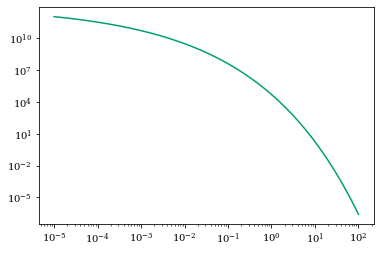

In [54]:
plt.plot(R, rho)
plt.xscale('log')
plt.yscale('log')

In [55]:
from scipy.optimize import bisect

def EinastoProfile(r, M, z):
    p_Einasto = profile_einasto.EinastoProfile(M=M, c=5., z=z, mdef = 'vir')
    return p_Einasto.densityInner(r)


def Einasto_CDF(r, profile, z):
    return profile.cumulativePdf(r, 1e2, z=z, mdef='vir')

def find_Einasto_icdf(p, cdf, profile, z):
    return bisect(lambda x: cdf(x, profile, z) - p, 0, 1e2)

def Einasto_icdf(u, profile, z):
    icdf = np.vectorize(lambda p: find_Einasto_icdf(p, Einasto_CDF, profile, z))
    return icdf(u)

p_Einasto = profile_einasto.EinastoProfile(M=1e6, c=5., z=10, mdef = 'vir')

Einasto_icdf(0.8, p_Einasto, 10)

array(1.06787108)

In [56]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.array([x.tolist(), y.tolist(), z.tolist()]).T

In [57]:
def Star_infos_generator(M_halo, N_star, z):

    # if N_star>0:

    Einasto = profile_einasto.EinastoProfile(M=M_halo, c=5., z=z, mdef = 'vir')

    rs = Einasto.par['rs']

    Rmax=5*rs

    v_m = ((((6/5*G.value*M_halo/Rmax)**(1/2))*(u.kpc/u.s)).to(u.km/u.s))

    un = np.random.uniform(0, 1, N_star)


    r_output = (Einasto_icdf(un, Einasto, z)*rs).tolist()
    theta_output = np.random.uniform(0, np.pi, N_star).tolist()
    phi_output = np.random.uniform(0, 2*np.pi, N_star).tolist()
    thetav_output = np.random.uniform(0, np.pi, N_star).tolist()
    phiv_output = np.random.uniform(0, 2*np.pi, N_star).tolist()

    v=(Einasto.circularVelocity(r_output)).tolist()

    print(r_output)
    return spherical_to_cartesian(r_output, theta_output, phi_output), spherical_to_cartesian(v, thetav_output, phiv_output)
    
    # else:
    #     return [0], [0], [0], [0], [0], [0]
    

In [58]:
x, v = Star_infos_generator(1e6, 2, 20)
x, v

[0.003752083079262907, 0.0010154092913046869]


(array([[-0.00038982,  0.00297863,  0.0022481 ],
        [-0.00011212, -0.00098813,  0.00020516]]),
 array([[-0.26954063, -1.04380424, -3.27545067],
        [-0.32699844, -0.29092658,  1.63697163]]))

In [59]:
g = (6.67430e-20*u.km**3/u.kg*u.s**2).to(u.km**3/u.kg*u.yr**2).value

m_1 = 50.02912029*constants.M_sun.value
m_2 = 14.24942889*constants.M_sun.value

R_1_0 = (x[0]*u.kpc).to(u.km).value  # km
R_2_0 = (x[1]*u.kpc).to(u.km).value  # km
dotR_1_0 = (v[0]*u.km/u.s).to(u.km/u.yr).value  # km/s
dotR_2_0 = (v[1]*u.km/u.s).to(u.km/u.yr).value  # km/s

y_0 = np.hstack((R_1_0, R_2_0, dotR_1_0, dotR_2_0))


def absolute_motion(t, y):
    """Calculate the motion of a two-body system in an inertial reference frame.

    The state vector ``y`` should be in the order:

    1. Coordinates of $m_1$
    2. Coordinates of $m_2$
    3. Velocity components of $m_1$
    4. Velocity components of $m_2$
    """
    # Get the six coordinates for m_1 and m_2 from the state vector
    R_1 = y[:3]
    R_2 = y[3:6]

    # Fill the derivative vector with zeros
    ydot = np.zeros_like(y)

    # Set the first 6 elements of the derivative equal to the last
    # 6 elements of the state vector, which are the velocities
    ydot[:6] = y[6:]

    # Calculate the acceleration terms and fill them in to the rest
    # of the derivative array
    r = np.sqrt(np.sum(np.square(R_2 - R_1)))
    ddot = g * (R_2 - R_1) / r ** 3
    ddotR_1 = m_2 * ddot
    ddotR_2 = -m_1 * ddot

    ydot[6:9] = ddotR_1
    ydot[9:] = ddotR_2
    return ydot

In [60]:
t_0 = 0  # seconds
t_f = 1e8  # seconds
t_points = np.linspace(t_0, t_f, int(t_f))

sol = integrate.solve_ivp(absolute_motion, [t_0, t_f], y_0, t_eval=t_points)

y = sol.y.T

R_1 = y[:, :3]  # km
R_2 = y[:, 3:6]  # km
V_1 = y[:, 6:9]  # km/s
V_2 = y[:, 9:]  # km/s

Barycenter = (m_1 * R_1 + m_2 * R_2) / (m_1 + m_2)  # km

In [ ]:
r_1 = R_1[::10000]
r_2 = R_2[::10000]
barycenter = (m_1 * r_1 + m_2 * r_2) / (m_1 + m_2)
distances = np.sqrt(np.sum((r_2 - r_1)**2, axis=1))

In [ ]:
distances

array([1.49141753e+14, 1.49956256e+14, 1.50778529e+14, ...,
       1.36317642e+16, 1.36331187e+16, 1.36344733e+16])

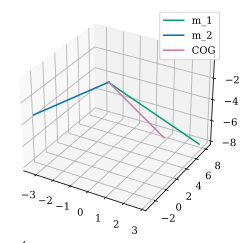

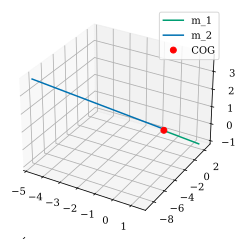

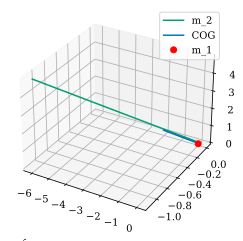

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(r_1[:, 0], r_1[:, 1], r_1[:, 2], label="m_1")
ax.plot(r_2[:, 0], r_2[:, 1], r_2[:, 2], label="m_2")
ax.plot(barycenter[:, 0], barycenter[:, 1], barycenter[:, 2], label="COG")
ax.legend()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
R1_rel_COG = r_1 - barycenter
R2_rel_COG = r_2 - barycenter
ax.plot(R1_rel_COG[:, 0], R1_rel_COG[:, 1], R1_rel_COG[:, 2], label="m_1")
ax.plot(R2_rel_COG[:, 0], R2_rel_COG[:, 1], R2_rel_COG[:, 2], label="m_2")
ax.plot(0, 0, 0, "ro", label="COG")
ax.legend()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
R2_rel_R1 = r_2 - r_1
COG_rel_R1 = barycenter - r_1
ax.plot(R2_rel_R1[:, 0], R2_rel_R1[:, 1], R2_rel_R1[:, 2], label="m_2")
ax.plot(COG_rel_R1[:, 0], COG_rel_R1[:, 1], COG_rel_R1[:, 2], label="COG")
ax.plot(0, 0, 0, "ro", label="m_1")
ax.legend()

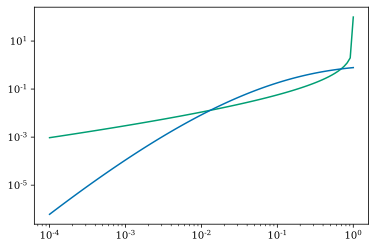

In [ ]:
r=np.logspace(-4, 0, 100)
plt.plot(r, Einasto_icdf(r, p_Einasto, 10.))
plt.plot(r, Einasto_CDF(r, p_Einasto, 10.))
plt.xscale('log')

plt.yscale('log')

In [ ]:
def Last_S_infos(M_stars, r_stars, theta_stars, phi_stars):

    def inf(x):
        return -np.sum(x*M_stars[0:-1])/M_stars[-1]

    r_stars.append(inf(r_stars))
    theta_stars.append(inf(theta_stars))
    phi_stars.append(inf(phi_stars))
    return r_stars, theta_stars, phi_stars    

In [ ]:
import itertools

def Merging_Time(M1, M2, R1, R2, v1, v2):

    M1 = M1*constants.M_sun
    M2 = M2*constants.M_sun
    R1 = (R1*u.kpc).to(u.km)
    R2 = (R2*u.kpc).to(u.km)

    mu = M1*M2/(M1+M2)
    m = M1+M2
    nu = mu/m

    c=constants.c.to(u.km/u.s)
    G=(constants.G.to(u.kpc**3/u.kg/u.s**2)).to(u.km**3/u.s**2/u.kg)
    v=np.linalg.norm(v2-v1)*u.km/u.s
    r=(np.linalg.norm(R2-R1)).to(u.km)
    t = ((5/256) * (c**5/G**3/m**2/mu*r**4 - c**5 * G * m /nu / v**8)).to(u.Myr)
    print(t)
    return t

def Stars_Selection(System, X, V):

    n_system = len(System)
    l_iter = np.arange(0, n_system, 1)
    combinations = list(itertools.combinations(l_iter, 2))
    T_merge = np.empty(len(combinations), dtype=object)

    for i in range(len(combinations)):
        M1, M2 = System[combinations[i][0]], System[combinations[i][1]]
        R1, R2 = X[combinations[i][0]], X[combinations[i][1]]
        V1, V2 = V[combinations[i][0]], V[combinations[i][1]]
        T_merge[i] = Merging_Time(M1, M2, R1, R2, V1, V2)
        if T_merge[i].value<13e9:
            print('I got one')

    return T_merge

In [ ]:
for i in range(N_h):
    infos = Star_infos_generator(Mass_Halos[i], int(round(N_star[i])), z)
    # print('there is ', int(round(N_star[i])), 'stars in this halos, and their mass are, ', Star_system[i])
    T_merge = Stars_Selection(Star_system[i], infos[0], infos[1])

[0.0009576506790022846, 0.0001316009653147463]
-2.1697636943078985e+28 Myr
I got one
[0.0010357086561028192, 0.005156282942099151, 0.0003893558686880112, 0.005221305805990722, 0.011849057252511064]
7.00998354586293e+29 Myr
-1.8745677302219314e+27 Myr
I got one
8.942014414871585e+28 Myr
1.826431883194055e+30 Myr
3.077520572960825e+30 Myr
1.3602689747180837e+31 Myr
2.893542231345072e+31 Myr
6.331827494313362e+29 Myr
9.927144968146586e+30 Myr
3.640055398169051e+30 Myr
[0.00961292645098075, 0.0005397631586514423]
5.419226983422958e+32 Myr
[0.0003596605127568377]
[7.75989692847789e-05, 0.0146265262236852]
7.658450911053797e+32 Myr
[0.0003376506620746535]
[0.0010400028940532517, 0.00021790330752587982]
1.1956264109689766e+27 Myr
[0.000647501172967809, 5.890891419786772e-05, 0.000186792603720552]
1.3165872869675946e+29 Myr
6.029512948437226e+29 Myr
-1.9660096104715716e+30 Myr
I got one
[0.0002625608983697666, 0.0010858284052861378]
2.6661472794853334e+30 Myr
[0.002755262893382454, 0.001406829

In [ ]:
H0= cosmo.H(0) 
def Time_z(z):
    return (2/3/(1+z)**(3/2)/H0).to(u.Myr)

def Redshift_t(t):
    return ((3/2*t*H0.to(u.Myr**-1))**(-2/3)).value-1

print('The simulatation will start at $t_i=$', Time_z(30), 'and finish at $t_f=$', Time_z(10), '. There will be ' , int((Time_z(10)-Time_z(30)).value), 'steps')
t_i = Time_z(30)
t_f = Time_z(30)

def redhsift_steps(step_number):
    if step_number <= int((Time_z(10)-Time_z(30)).value):
        steped_time = t_i + step_number * u.Myr
        print(Redshift_t(steped_time))
        return Redshift_t(steped_time)
    else:
        print('The simulation is finished')
        return False
  
simulation_finished = False
for i in range(300):
    simulation_finished = redhsift_steps(i)
    if not simulation_finished:
        break

The simulatation will start at $t_i=$ 54.48214833281632 Myr and finish at $t_f=$ 257.75537907145053 Myr . There will be  203 steps
29.999999999999996
29.626379800960695
29.263817220144123
28.91179777320293
28.569839325979252
28.23748954922341
27.914323612455714
27.599942090968455
27.293969063164436
26.99605037818989
26.70585207620883
26.42305894573808
26.147373204263655
25.878513289928563
25.61621275345242
25.36021924064234
25.11029355690559
24.866208806098104
24.627749596855637
24.394711310270946
24.16689942341372
23.944128883749883
23.726223530013844
23.51301555552795
23.304345010355746
23.10005933902478
22.9000129508664
22.704066820298333
22.512088114624916
22.32394984715306
22.139530553622162
21.958713990126174
21.781388850867785
21.607448504230454
21.436790745785544
21.269317566970372
21.1049349382805
20.94355260591647
20.785083900913445
20.629445559861875
20.47655755639982
20.326342942723613
20.178727700423302
20.033640600004095
19.891013068504844
19.75077906466997
19.61287496117